# Compare Energies with Different Methods
We have a database computed with TTM, DFT and MP2. Let's see how they compare

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from ase.db import connect
from ase import units
import pandas as pd

## Load in the Data
Get the data from the different databases, combine them into a single dataframe

In [2]:
def load_database_to_pandas(path: str, name: str) -> pd.DataFrame:
    """Read an ASE database to a Pandas dataframe
    
    Args:
        path: Path to the ASE databases
    Returns:
        Dataframe with the filename as the key
    """
    with connect(path) as db:
        results = []
        for row in db.select(""):
            results.append({'filename': row['filename'],
                            'n_waters': int(row.natoms // 3),
                            f'runtime_{name}': row['runtime'],
                            f'energy_{name}': row['energy']})
        data = pd.DataFrame(results)

    data.set_index('filename', inplace=True)
    return data

In [3]:
data = pd.concat([
    load_database_to_pandas(path, name)
    for path, name in [
        ('initial-ttm.db', 'ttm'), ('initial-psi4.db', 'dft'),
        ('initial.db', 'mp2')
    ]
],
    axis=1)

Convert TTM to eV

In [4]:
data['energy_ttm'] /= units.Hartree

Drop duplicate columns

In [5]:
data = data.loc[:,~data.columns.duplicated()].copy()

In [6]:
data.head()

,n_waters,runtime_ttm,energy_ttm,runtime_dft,energy_dft,runtime_mp2,energy_mp2
filename,,,,,,,
mctbp_10002.xyz,9,0.003316,-2.783179,4.414176,-18614.680465,413.422554,-18680.458656
mctbp_10200.xyz,9,0.001862,-2.454002,4.068678,-18613.705891,330.860819,-18680.140512
mctbp_10597.xyz,9,0.001298,-2.379269,4.361022,-18614.052246,607.606075,-18679.932392
mctbp_1075.xyz,4,0.000624,-0.745407,1.100244,-8271.778945,98.875375,-8301.918930
mctbp_10767.xyz,9,0.001234,-1.860024,4.116375,-18612.928818,674.078150,-18679.324015


Compute the energy per water

In [13]:
for name in ['dft', 'ttm', 'mp2']:
    ref_energy = data[f'energy_per_water_{name}'][lowest_energy]
    data[f'energy_normed_{name}'] = data[f'energy_per_water_{name}'] - ref_energy
    print(f'Reference energy for {name}: {ref_energy:.2f} eV/water')

Reference energy for dft: -2068.58 eV/water
Reference energy for ttm: -0.40 eV/water
Reference energy for mp2: -2075.73 eV/water


Normalize by the energy above the most-stable cluster

In [8]:
lowest_energy = data['energy_per_water_mp2'].idxmin()

In [9]:
for name in ['dft', 'ttm', 'mp2']:
    data[f'energy_normed_{name}'] = data[f'energy_per_water_{name}'] - data[f'energy_per_water_{name}'][lowest_energy]

In [10]:
data[[c for c in data.columns if 'normed' in c]].sort_values('energy_normed_mp2').head(15)

,energy_normed_dft,energy_normed_ttm,energy_normed_mp2
filename,,,
min_1930862.xyz,0.000000,0.000000,0.000000
min_2249639.xyz,-0.000656,-0.001221,0.000512
min_1933997.xyz,-0.000186,0.000814,0.001784
min_1932988.xyz,-0.000881,0.000609,0.002286
min_1943025.xyz,0.014988,0.002038,0.003530
min_1948890.xyz,0.000047,0.002591,0.003737
min_1937085.xyz,0.011075,0.001326,0.003898
min_1982257.xyz,0.015655,0.004937,0.004617
min_2278464.xyz,-0.006570,0.002193,0.005126


In [11]:
data.iloc[0]

n_waters                    9.000000
runtime_ttm                 0.003316
energy_ttm                 -2.783179
runtime_dft                 4.414176
energy_dft             -18614.680465
runtime_mp2               413.422554
energy_mp2             -18680.458656
energy_per_water_dft    -2068.297829
energy_per_water_ttm       -0.309242
energy_per_water_mp2    -2075.606517
energy_normed_dft           0.283034
energy_normed_ttm           0.091388
energy_normed_mp2           0.123520
Name: mctbp_10002.xyz, dtype: float64

## Plot
Show how different things are between TTM and DFT

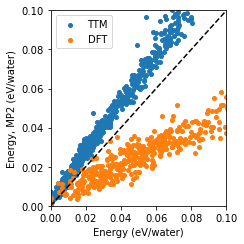

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

for name in ['ttm', 'dft']:
    ax.scatter(data[f'energy_normed_{name}'], data['energy_normed_mp2'], label=name.upper(), s=16)
    
ax.legend()

# Set the xlim
ax.set_xlabel('Energy (eV/water)')
ax.set_ylabel('Energy, MP2 (eV/water)')
ax.set_xlim([0, 0.1])
ax.set_ylim([0, 0.1])

max_lim = max(ax.get_xlim() + ax.get_ylim())
ax.plot([0, max_lim], [0, max_lim], 'k--')

fig.tight_layout()